In [3]:
print("hello world")

hello world


In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np

print("imports complete")

imports complete


In [5]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [6]:
# Shrink data function

def filter_data(X, y, numeric_cols, gamma, use_mahalanobis, path_name=None):
    if use_mahalanobis:
        # Mahalanobis Distance function
        def mahalanobis(x):
            return np.sqrt((x - mean) @ inv_cov @ (x - mean).T)
        

        mean = X.mean(axis=0)
        cov = np.cov(X, rowvar=False)
        inv_cov = np.linalg.pinv(cov)


        X["md"] = [mahalanobis(x) for x in X.values]

        print(X["md"])

        # Trim based on percentile thresholds
        low_p, high_p = gamma, 1 - gamma
        low_val = X["md"].quantile(low_p)
        high_val = X["md"].quantile(high_p)

        mask = pd.Series([True] * X.shape[0])
        for i in range(X.shape[0]):
            mask[i] = low_val <= X["md"][i]  <= high_val
        
        X = X.drop(columns=["md"])
        

    else:
        def compute_shrunk_bounds(df, numeric_cols, gamma=0.1, low_pct=1.0, high_pct=99.0):
            # df: raw data
            mins = df[numeric_cols].quantile(low_pct/100.0).values
            maxs = df[numeric_cols].quantile(high_pct/100.0).values
            spans = maxs - mins
            # avoid zero spans
            spans[spans == 0] = 1e-6
            low = mins + gamma * spans
            high = maxs - gamma * spans
            return low, high
        
        low_bounds, high_bounds = compute_shrunk_bounds(X, numeric_cols, gamma=gamma)

        mask = pd.Series([True] * X.shape[0])
        for i, col in enumerate(numeric_cols):
            mask &= (X[col] >= low_bounds[i]) & (X[col] <= high_bounds[i])


    # Do the shrinking
    X_shrunk, y_shrunk = X[mask], y[mask]
    X_out, y_out = X[~mask], y[~mask]

    X_shrunk = X_shrunk.reset_index(drop=True)
    y_shrunk = y_shrunk.reset_index(drop=True)

    # Save to file
    if path_name:
        in_distribution_file = path_name + "in_distribution.csv"
        out_distribution_file = path_name + "out_of_distribution.csv"

        output_data = pd.concat([X_shrunk, y_shrunk], axis=1)
        output_data.to_csv(in_distribution_file, index=False)

        output_data = pd.concat([X_out, y_out], axis=1)
        output_data.to_csv(out_distribution_file, index=False)


    return X_shrunk, y_shrunk, X_out, y_out


# Training model function

def train_model(X, y, model, criterion, optimizer, filename=None):
    # Ready data
    X = pd.get_dummies(X, drop_first=True)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # "fit" learns the mean/variance of each feature
    X_test = scaler.transform(X_test)  # fit isn't necessary because the scaler already learned the features

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train.values.squeeze(), dtype=torch.long)
    y_test = torch.tensor(y_test.values.squeeze(), dtype=torch.long)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train.argmax(dim=1)) # convert to class indicies
        loss.backward()     # backprop
        optimizer.step()    # update gradients

        print(f"Epoch {epoch+1}/{num_epochs}: loss {loss}")

    # Output test accuracy
    predictions = model(X_test)
    _, predicted_classes = torch.max(predictions, 1)
    accuracy = (predicted_classes == y_test.argmax(dim=1)).float().mean()
    print(f"Test Accuracy: {accuracy.item()*100:.2f}%")

    # Verify that weights can be saved
    if filename:
        torch.save(model.state_dict(), filename)
        print("Model weights saved to " + filename)

In [7]:
# Research infrastructure
# Given dataset name OR pure data file upload, this file needs to create an MLP, train it, and output the weights to a file
# There should also be a parameter for shrunk data or not (this takes a parameter for how much data from each side to filter)


###### 1. LOAD DATASET ######

# Option 1: UCI Dataset
# uci_function = datasets.load_wine                                  # Parameter
# dataset = uci_function()
# class_names = dataset.target_names
# X = pd.DataFrame(dataset.data, columns=dataset.feature_names)
# y = pd.DataFrame(dataset.target, columns=['target'])
# y = pd.get_dummies(y['target'])
# y.columns = class_names


# Option 2: Load data from file
dataset = pd.read_csv('../data/kidney/datasets/raw_data/kidney_modified.csv')                                  # Parameter
class_names = ["CKD_Status_0", "CKD_Status_1"]                                        # Parameter
X = dataset.drop(columns=class_names)                                        # May need to undo one-hot encoding here...
X = pd.get_dummies(X, drop_first=True)
y = dataset[class_names]
# y = pd.get_dummies(y[class_names[0]])
y.columns = class_names


categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

bool_cols = X.select_dtypes(include='bool').columns
for col in bool_cols:
    X[col] = X[col].astype(int)


switch_features = ["Diabetes", "Hypertension"]
for feature in switch_features:
    numeric_features.remove(feature)
    categorical_features.append(feature)

print(X.head())
print(y.head())
print(class_names)

print(categorical_features)
print(numeric_features)

print("\nData loaded")


   Creatinine        BUN         GFR  Urine_Output  Diabetes  Hypertension  \
0    0.788803   8.386869  102.161787   1632.649387         0             0   
1    3.413970  53.688796   50.071257    935.540516         1             0   
2    0.647645   7.466540   89.451831   1774.553846         1             1   
3    0.795508  12.516821   99.872180   2360.602980         0             0   
4    0.869010  19.855960   86.110182   1987.750901         0             1   

         Age  Protein_in_Urine  Water_Intake  Medication_ACE Inhibitor  \
0  27.682074        106.700203      1.570370                         0   
1  33.122208        410.008362      3.425287                         1   
2  55.832284        123.336925      1.123301                         0   
3  32.391900        116.098870      3.086846                         1   
4  66.689515         55.668760      2.174980                         0   

   Medication_ARB  Medication_Diuretic  
0               0                    0  
1   

In [8]:
###### 2. SHRINK DATASET ######
# Optionally filter out data that is outside some percentage range

gamma = 0.1
use_mahalanobis = False
filename = "../data/kidney/datasets/baseline/80_percent/"

X_shrunk, y_shrunk, X_out, y_out = filter_data(X, y, numeric_features, gamma, use_mahalanobis, filename)

print("Old X size: ", X.shape)
print("New X size: ", X_shrunk.shape)
print("Old y size: ", y.shape)
print("New y size: ", y_shrunk.shape)

# don't do one-hot encoding...?


Old X size:  (5000, 12)
New X size:  (305, 12)
Old y size:  (5000, 2)
New y size:  (305, 2)


In [40]:
###### 3. TRAIN MODEL ######

# X_model, y_model = X, y
X_model, y_model = X_shrunk, y_shrunk

input_dim = X_model.shape[1]
print(input_dim)
num_classes = 2
model = MLP(input_dim, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

filename = "../data/kidney/model_weights/baseline/99.8_percent.pth"

train_model(X_model, y_model, model, criterion, optimizer, filename)


12
Epoch 1/100: loss 0.7367765307426453
Epoch 2/100: loss 0.7289317846298218
Epoch 3/100: loss 0.7211886644363403
Epoch 4/100: loss 0.7135372757911682
Epoch 5/100: loss 0.7059708833694458
Epoch 6/100: loss 0.6984823942184448
Epoch 7/100: loss 0.6910566687583923
Epoch 8/100: loss 0.6836760640144348
Epoch 9/100: loss 0.6763407588005066
Epoch 10/100: loss 0.6690279245376587
Epoch 11/100: loss 0.6617138981819153
Epoch 12/100: loss 0.6543909311294556
Epoch 13/100: loss 0.6470404863357544
Epoch 14/100: loss 0.6396394371986389
Epoch 15/100: loss 0.6321654319763184
Epoch 16/100: loss 0.6246082186698914
Epoch 17/100: loss 0.6169638633728027
Epoch 18/100: loss 0.6092135906219482
Epoch 19/100: loss 0.6013501286506653
Epoch 20/100: loss 0.5933600664138794
Epoch 21/100: loss 0.5852404832839966
Epoch 22/100: loss 0.5769944787025452
Epoch 23/100: loss 0.5686219930648804
Epoch 24/100: loss 0.5601240396499634
Epoch 25/100: loss 0.5514989495277405
Epoch 26/100: loss 0.5427526831626892
Epoch 27/100: loss

In [41]:
###### 4. EVALUATE AGAINST BASELINE ######
# X, y store the baseline data


X_tensor = StandardScaler().fit_transform(X)
X_tensor = torch.tensor(X_tensor, dtype=torch.float32)
y_tensor = torch.tensor(y.values.squeeze(), dtype=torch.long)

predictions = model(X_tensor)
_, predicted_classes = torch.max(predictions, 1)
accuracy = (predicted_classes == y_tensor.argmax(dim=1)).float().mean()
print(f"Baseline Accuracy: {accuracy.item()*100:.2f}%")


# Also run against in-distribution and out-of-distribution data
X_tensor = StandardScaler().fit_transform(X_shrunk)
X_tensor = torch.tensor(X_tensor, dtype=torch.float32)
y_tensor = torch.tensor(y_shrunk.values.squeeze(), dtype=torch.long)

predictions = model(X_tensor)
_, predicted_classes = torch.max(predictions, 1)
accuracy = (predicted_classes == y_tensor.argmax(dim=1)).float().mean()
print(f"In-distribution Accuracy: {accuracy.item()*100:.2f}%")


X_tensor = StandardScaler().fit_transform(X_out)
X_tensor = torch.tensor(X_tensor, dtype=torch.float32)
y_tensor = torch.tensor(y_out.values.squeeze(), dtype=torch.long)

predictions = model(X_tensor)
_, predicted_classes = torch.max(predictions, 1)
accuracy = (predicted_classes == y_tensor.argmax(dim=1)).float().mean()
print(f"Out-of-distribution Accuracy: {accuracy.item()*100:.2f}%")



Baseline Accuracy: 98.82%
In-distribution Accuracy: 98.33%
Out-of-distribution Accuracy: 93.29%


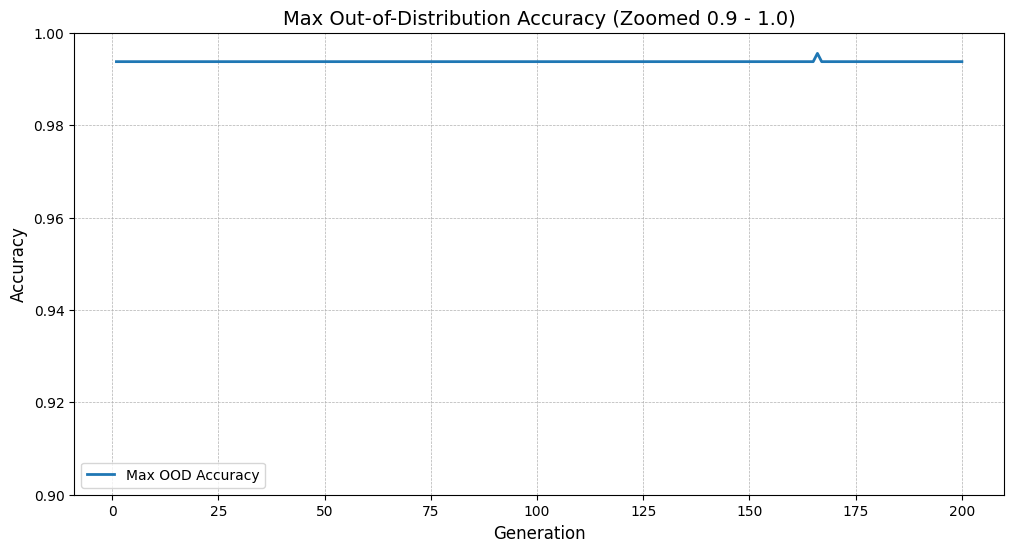

In [1]:
# graph creation

import pandas as pd
import matplotlib.pyplot as plt

# 1. Load your data
# Assuming your data is in a CSV file named 'results.csv'
# df = pd.read_csv('results.csv')

# For this example, I am loading the data directly from the text you provided:
# data = """generation,checkpoint_id,cid_min___b_score_vector,cid_max___b_score_vector,max_baseline_accuracy,min_baseline_accuracy,mean_baseline_accuracy,elites_mean_baseline_accuracy,cid_min_baseline_accuracy,cid_max_baseline_accuracy,max_in_distribution_accuracy,min_in_distribution_accuracy,mean_in_distribution_accuracy,elites_mean_in_distribution_accuracy,cid_min_in_distribution_accuracy,cid_max_in_distribution_accuracy,max_out_of_distribution_accuracy,min_out_of_distribution_accuracy,mean_out_of_distribution_accuracy,elites_mean_out_of_distribution_accuracy,cid_min_out_of_distribution_accuracy,cid_max_out_of_distribution_accuracy,max_score,min_score,mean_score,elites_mean_score,cid_min_score,cid_max_score
# [PASTE YOUR CSV DATA HERE OR LOAD FROM FILE]
# """
# Note: In a real script, just use pd.read_csv('filename.csv')


df = pd.read_csv('../../accuracy/11_30_2025__large_data_experiment/kidney/mix/99.8_percent/experiment_stats.csv')


# 2. Setup the Plot
plt.figure(figsize=(12, 6))

# 3. Plot the specific column
# We plot Generation on X and Max OOD Accuracy on Y
plt.plot(df['generation'], df['max_out_of_distribution_accuracy'], 
         color='#1f77b4', linewidth=2, label='Max OOD Accuracy')

# 4. SET THE Y-AXIS LIMITS (This is the step you asked for)
plt.ylim(0.9, 1.0)

# 5. Add labels and styling for readability
plt.title('Max Out-of-Distribution Accuracy (Zoomed 0.9 - 1.0)', fontsize=14)
plt.xlabel('Generation', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# 6. Show the plot
plt.show()
